### Define and find local maxima-clusters. Find associations (clusters, groups, NGC galaxies)

In this notebook I find local maxima in the distribution of the LSBGs (clusters) and associate these maxima with galaxy clusters, galaxy groups, and NGC galaxies.

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [2]:
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import KernelDensity

### Part I: Kernel Density Estimation of the overdensity field

In [3]:
# Import the coordinates of the LSBGs objects
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)
ra, dec= np.loadtxt("LSBGs_properties_tot.dat", usecols=(1,2), unpack=3)
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.
        
latlon = np.vstack([dec,ra]).T

In [4]:
# Import the Healpix footprint
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [5]:
x_min = -70.; x_max = 110.
y_min = - 70; y_max = 10.
# ============================
# Define the aspect ratio
asp_rat = (x_max-x_min)/(y_max - y_min)
base_points = 400
y_points = base_points
x_points = int(asp_rat*base_points)

In [6]:
# Create a grid of positions over which we are going to calculate the KDE
x_grid = np.linspace(x_min,x_max,x_points)
y_grid = np.linspace(y_min,y_max,y_points)

X, Y = np.meshgrid(x_grid,y_grid)
xy = np.vstack([Y.ravel(),X.ravel()]).T

Now keep only those points that are within the DES footprint.

In [7]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1 

In [8]:
# Get the healpix indices xy points
HP_ind = hp.ang2pix(4096, xy[:,1], xy[:,0], lonlat=True)
xy = np.radians(xy)

In [9]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

ra_loc = xy[:,1]
dec_loc = xy[:,0]

# Keep those with LOCAL_mask = 1
ra_pos = ra_loc[LOCAL_mask==1]
dec_pos = dec_loc[LOCAL_mask==1]

#land_mask = np.vstack()
land_mask = xy[LOCAL_mask==1]

Now, fit our KDE 

In [10]:
kern_size = 0.0052
# Fit now 
kde = KernelDensity(bandwidth=kern_size, kernel='gaussian', metric='haversine')
kde.fit(np.radians(latlon))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.0052, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

In [11]:
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy))
Z[LOCAL_mask==0] = 0
Z = Z.reshape(X.shape)

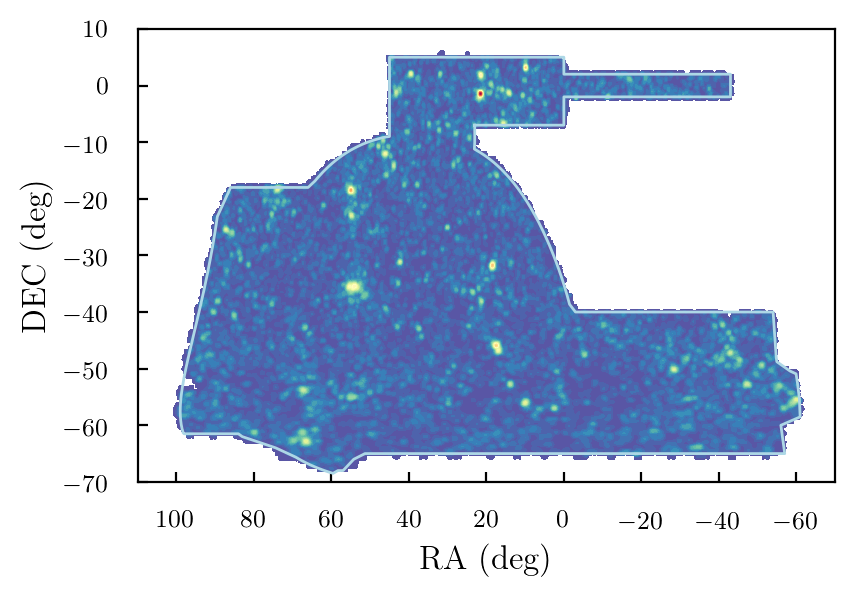

In [16]:
plt.figure(figsize = (4.5,3.0))

levels = np.linspace(1e-6, Z.max(),40)

plt.plot(ra_DES, dec_DES, c='lightblue', linewidth=1.0)
plt.contourf(X,Y,Z, levels=levels, cmap='Spectral_r')

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=12);plt.ylabel('DEC (deg)', fontsize=12)
plt.show()

### 3, 4 and 5 sigma clipping

In [17]:
from clip import sigma_clip
Z_rav = Z.ravel()
Z_for_clip = Z_rav[Z_rav>0]
# ===================================================================
# ===================================================================
filt_z_3sigma, low_3sigma, up_3sigma = sigma_clip(Z_for_clip, sigma=3, maxiters=12,return_bounds=True) 
filt_z_4sigma, low_4sigma, up_4sigma = sigma_clip(Z_for_clip, sigma=4, maxiters=12,return_bounds=True) 
filt_z_5sigma, low_5sigma, up_5sigma = sigma_clip(Z_for_clip, sigma=5, maxiters=12,return_bounds=True) 

In [18]:
from scipy.stats import gaussian_kde

#Fit kernel
kernel = gaussian_kde(Z_for_clip)
# Evaluate in a number of points an plot to see
kde_points_eval  = np.linspace(-1.0,4.0,200)
kde_val =  kernel(kde_points_eval)

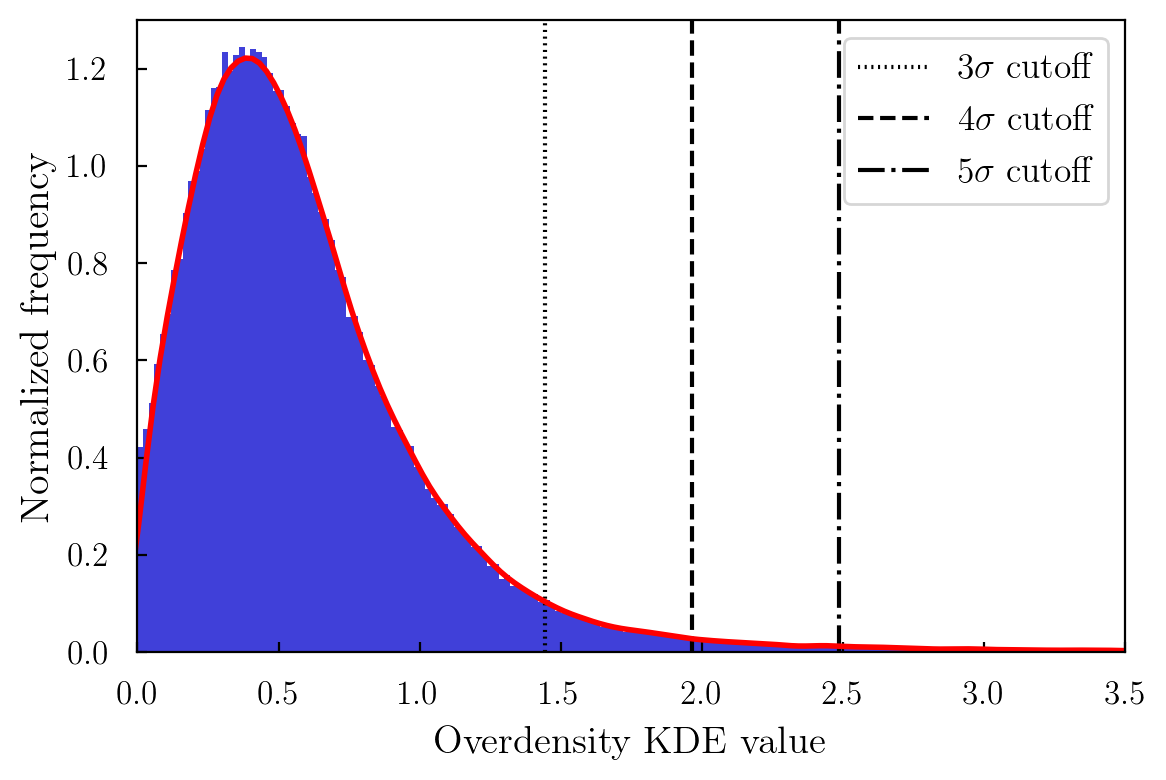

In [19]:
plt.figure(figsize = (5.91,4.0))

#plt.plot(kde_points_eval,kde_val, c='red', label='kde')
plt.hist(Z_for_clip,range=[0,4], bins=200, color='mediumblue', density=True, alpha=0.75)
plt.plot(kde_points_eval,kde_val, c='red', linewidth=2)


plt.vlines(up_3sigma,0,1.3, color='k', linestyle=':',label='3$\sigma$ cutoff')
plt.vlines(up_4sigma,0,1.3, color='k', linestyle='--',label='4$\sigma$ cutoff')
plt.vlines(up_5sigma,0,1.3, color='k', linestyle='-.',label='5$\sigma$ cutoff')


# ===================================================================
plt.legend(loc='upper right', frameon=True, fontsize=12.8)
plt.xlim(-0.,3.5);plt.ylim(0,1.3)
plt.xlabel('Overdensity KDE value', fontsize=14);plt.ylabel('Normalized frequency', fontsize=14.5)
plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('Hist_clipping.pdf', dpi=300)
plt.show()

### Find and plot the 3, 4, 5 $\sigma$ maxima

In [22]:
from skimage.feature import peak_local_max
# ========================================
# ========================================

# First find the peaks that lie 3 sigma above the mean
xy_3sigma = peak_local_max(Z, min_distance=1,threshold_abs=up_3sigma)
# First find the peaks that lie 4 sigma above the mean
xy_4sigma = peak_local_max(Z, min_distance=1,threshold_abs=up_4sigma)
# Second find the peaks that lie 5 sigma above the mean
xy_5sigma = peak_local_max(Z, min_distance=1,threshold_abs=up_5sigma)

# Print their sizes
print(np.shape(xy_3sigma)[0])
print(np.shape(xy_4sigma)[0])
print(np.shape(xy_5sigma)[0])

429
171
96


In [23]:
# Get their ra and dec
# ====================================================
# ====================================================
# ====================================================
# For the three sigma points first
ra_s_like = xy_3sigma[:,1];dec_s_like = xy_3sigma[:,0]
ra_max_3sigma = x_grid[ra_s_like];dec_max_3sigma = y_grid[dec_s_like]
# ====================================================
# ====================================================
# For the four sigma points first
ra_s_like = xy_4sigma[:,1];dec_s_like = xy_4sigma[:,0]
ra_max_4sigma = x_grid[ra_s_like];dec_max_4sigma = y_grid[dec_s_like]
# ====================================================
# ====================================================
# For the 5 sigma points now
ra_s_like = xy_5sigma[:,1];dec_s_like = xy_5sigma[:,0]
ra_max_5sigma = x_grid[ra_s_like];dec_max_5sigma = y_grid[dec_s_like]

Now, separate them; in other words find those that are above 3$\sigma$ but below 4$\sigma$, those that are above 4$\sigma$ but below 5$\sigma$ and those that are above 5$\sigma$. There should be 258 in the first category, 75 in the second category and 96 in the third category.

In [24]:
len_3s = np.shape(xy_3sigma)[0]
len_4s = np.shape(xy_4sigma)[0]
len_5s = np.shape(xy_5sigma)[0]

doubles_34 = np.zeros(len_3s) #Those in max 3 sigma that are also in 4 sigma

for i in range(len_3s):
    for j in range(len_4s):
        if ((ra_max_4sigma[j]==ra_max_3sigma[i])&(dec_max_4sigma[j]==dec_max_3sigma[i])):
            doubles_34[i] = int(1)
            break
            
doubles_34 = doubles_34.astype(int)
# ================================================
# ================================================
doubles_45 = np.zeros(len_4s) # Those in max 4 sigma that are also in 5 sigma

for i in range(len_4s):
    for j in range(len_5s):
        if ((ra_max_5sigma[j]==ra_max_4sigma[i])&(dec_max_5sigma[j]==dec_max_4sigma[i])):
            doubles_45[i] = int(1)
            break
            
doubles_45 = doubles_45.astype(int)

In [25]:
ra_3s = ra_max_3sigma[doubles_34==0];dec_3s = dec_max_3sigma[doubles_34==0]
ra_4s = ra_max_4sigma[doubles_45==0];dec_4s = dec_max_4sigma[doubles_45==0]
ra_5s = ra_max_5sigma;dec_5s = dec_max_5sigma 
print(len(ra_3s))
print(len(ra_4s))
print(len(ra_5s))

258
75
96


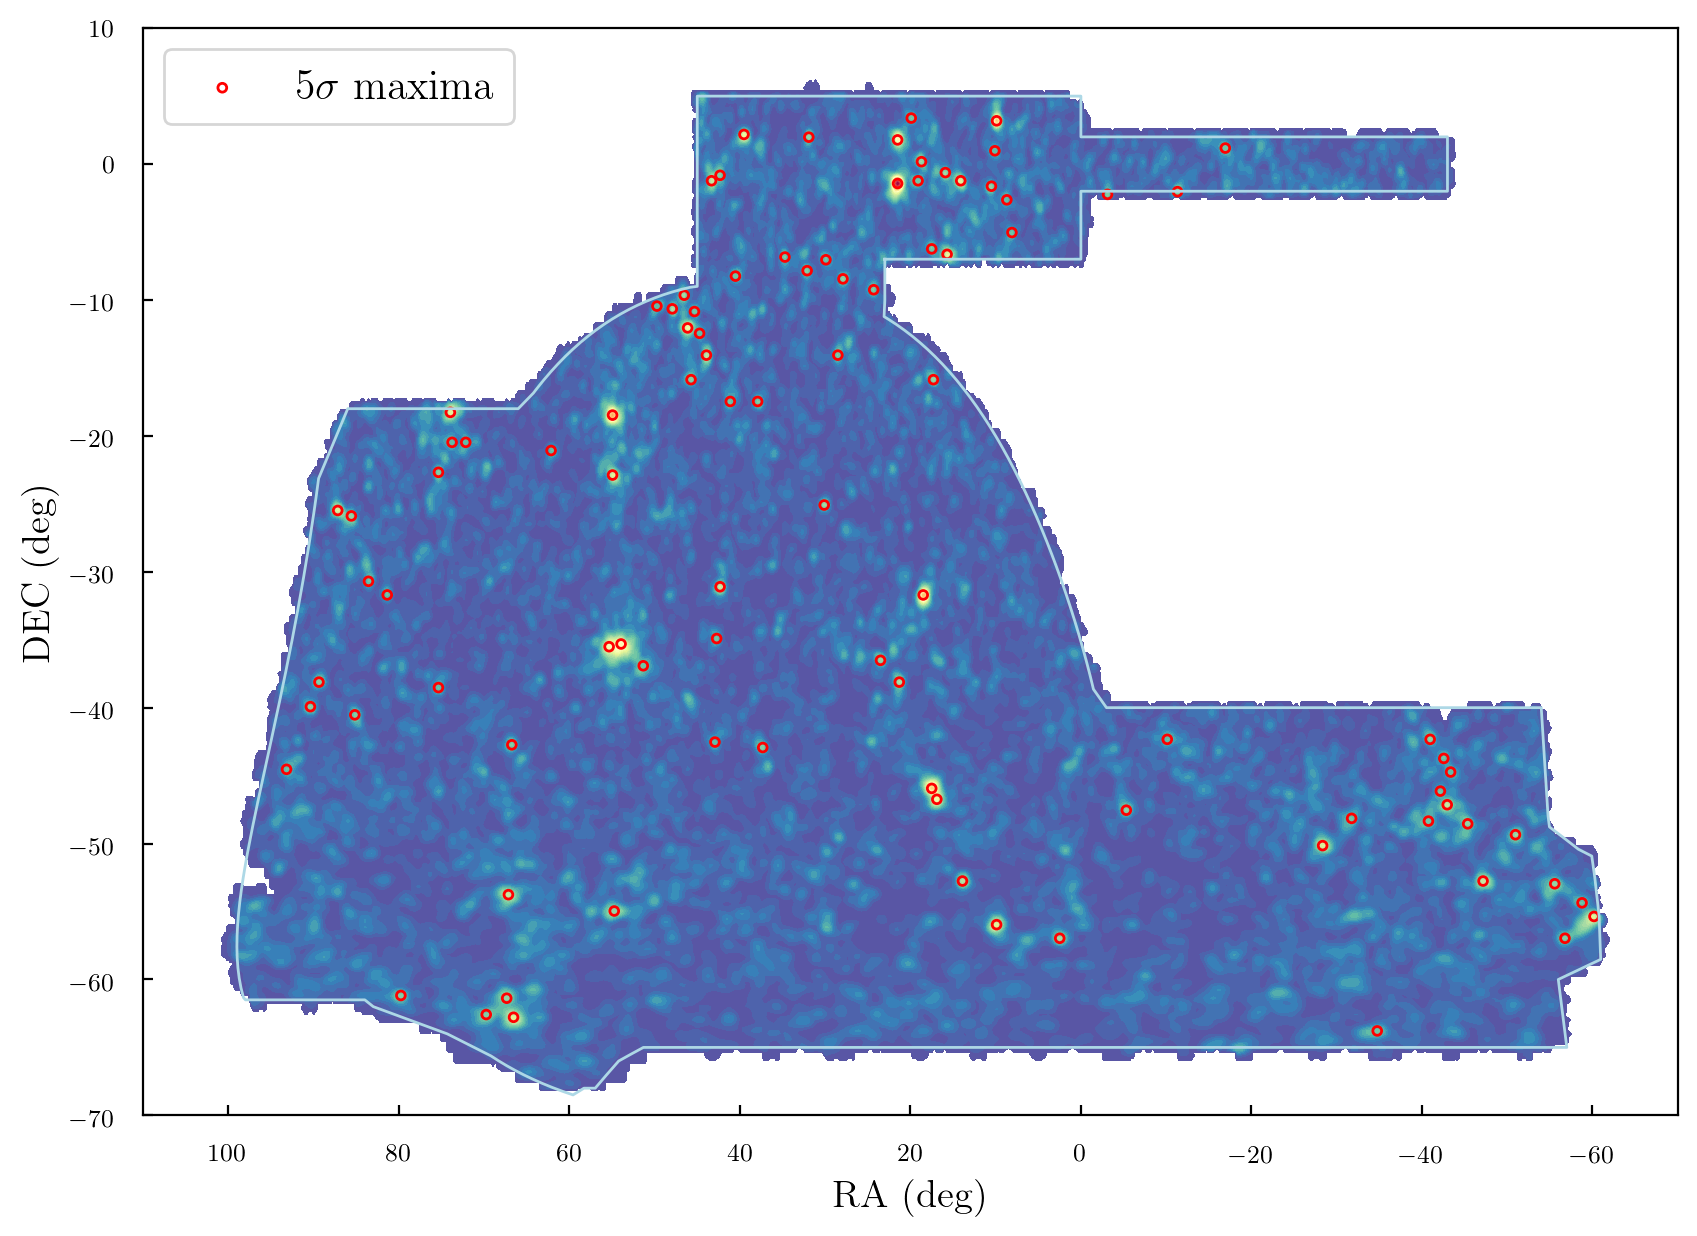

In [38]:
plt.figure(figsize = (0.9*11.0,0.9*8.0))

levels = np.linspace(1e-6, Z.max(),40)

plt.plot(ra_DES, dec_DES, c='lightblue', linewidth=1.0)
plt.contourf(X,Y,Z, levels=levels, cmap='Spectral_r')
#plt.scatter(ra_3s, dec_3s, c='k', s=2.5, label='$3\sigma$ maxima')
#plt.scatter(ra_4s, dec_4s, c='firebrick', s=2.5, marker='^', label='$4\sigma$ maxima')
plt.scatter(ra_5s, dec_5s, s=10,facecolors='none', edgecolors='r', label='$5\sigma$ maxima')

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=14);plt.ylabel('DEC (deg)', fontsize=14)
plt.legend(loc='upper left', frameon=True, fontsize=15)
plt.show()

## Import external catalogs

### Abell catalog

In [54]:
# Open and read the Abell catalog
Abell_cat = fits.open('Abell.fits')
# ================================================
name_Abell = Abell_cat[1].data['NAME']
ra_Abell = Abell_cat[1].data['RA']
dec_Abell = Abell_cat[1].data['DEC']
z_Abell = Abell_cat[1].data['REDSHIFT']
rich_Abell = Abell_cat[1].data['RICH']
dist_Abell = Abell_cat[1].data['DIST']
# Transform RA and DEC
# ================================================
# ================================================
for i in range(len(ra_Abell)):
    if (ra_Abell[i] > 180.):
        ra_Abell[i] = ra_Abell[i]-360.
# ====================================
# ====================================
#print Abell_cat[1].header.keys

### Reflex catalog

In [66]:
# Open and read the Abell catalog
Reflex_cat = fits.open('Reflex.fits')

name_Reflex = Reflex_cat[1].data['name']
ra_Reflex = Reflex_cat[1].data['ra']
dec_Reflex = Reflex_cat[1].data['dec']
z_Reflex = Reflex_cat[1].data['redshift']

for i in range(len(ra_Reflex)):
    if (ra_Reflex[i] > 180.):
        ra_Reflex[i] = ra_Reflex[i]-360.

#print Reflex_cat[1].header.keys

### NGC catalog (keep only the galaxies)

In [74]:
# =============================================
# Open and read the NGC catalog
NGC_cat = fits.open('NGC_2.fit')

# ================================================
ra_NGC = NGC_cat[1].data['_RAJ2000']
dec_NGC = NGC_cat[1].data['_DEJ2000']
type_NGC = NGC_cat[1].data['Type']
name_NGC = NGC_cat[1].data['NGC']
ra_NGC = ra_NGC[type_NGC==5]
dec_NGC = dec_NGC[type_NGC==5]
name_NGC = name_NGC[type_NGC==5]
type_NGC = type_NGC[type_NGC==5]

        
for i in range(len(ra_NGC)):
    if (ra_NGC[i] > 180.):
        ra_NGC[i] = ra_NGC[i]-360.

#print NGC_cat[1].header.keys

### 2Mass group catalog 

From arXiv: 1503.03134: 
Galaxy Groups: A 2MASS Catalog


In [105]:
# =============================================
# Open and read the NGC catalog
twomass_cat = fits.open('2Mass.fit')


ra_2Mass = twomass_cat[1].data['_RA_ICRS']
dec_2Mass = twomass_cat[1].data['_DE_ICRS']
Nmb_2Mass = twomass_cat[1].data['Nmb']
name_2Mass = twomass_cat[1].data['Nest']

# Keep only those with >=5 members
ra_2Mass = ra_2Mass[Nmb_2Mass>=5]
dec_2Mass = dec_2Mass[Nmb_2Mass>=5]
name_2Mass = name_2Mass[Nmb_2Mass>=5]
Nmb_2Mass = Nmb_2Mass[Nmb_2Mass>=5]


for i in range(len(ra_2Mass)):
    if (ra_2Mass[i] > 180.):
        ra_2Mass[i] = ra_2Mass[i]-360.

#print twomass_cat[1].header.keys

### Catalog from : Galaxy Groups within 3500 km s−1

Call this "group catalog". From Kourkchi & Tully, arXiv: 1705.08068

In [114]:
# =============================================
# Open and read the group catalog
Group_cat = fits.open('2_mass_new.fit')

#print Mass_cat[1].header.keys
name_group = Group_cat[1].data['PGC1']
ra_group = Group_cat[1].data['_RA_icrs']
dec_group = Group_cat[1].data['_DE_icrs']
Nm_group = Group_cat[1].data['Nm']

# Keep only those with >=5 members
name_group = name_group[Nm_group>=5]
ra_group = ra_group[Nm_group>=5]
dec_group = dec_group[Nm_group>=5]
Nm_group = Nm_group[Nm_group>=5]

for i in range(len(ra_group)):
    if (ra_group[i] > 180.):
        ra_group[i] = ra_group[i]-360.

#print Group_cat[1].header.keys